The Transformers library by Hugging Face:

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 6.8 MB 60.6 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 


In [ ]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.16.2



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device=torch.device("cuda")

In [ ]:
df = pd.read_csv("/content/sample_data/covid19_tweets[1].csv", nrows=15000)
df.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,GenerasiYeremia,‏האנטיכריסט יופיע בקרוב. סימני הופעתו מתחזקים ...,1 Korintus 10:23; Daniel 9:27,1869,2365,7415,2020-05-18 12:44:27,2021-01-18 05:20:36,0,@TheBelieverJC Amen\n\n#Akhirzaman\n#Endtimes\...,"[{'text': 'Akhirzaman', 'indices': [21, 32]}, ..."
1,CuyahogaOEM,Cuyahoga Co. Office of Emergency Management. S...,"Cuyahoga County, OH",212,1180,8687,2014-08-20 18:02:05,2021-01-18 05:20:32,47,Our new vaccine provider tool shows locations ...,"[{'text': 'COVID19', 'indices': [113, 121]}]"
2,GenerasiYeremia,‏האנטיכריסט יופיע בקרוב. סימני הופעתו מתחזקים ...,1 Korintus 10:23; Daniel 9:27,1869,2365,7415,2020-05-18 12:44:27,2021-01-18 05:20:31,0,Amen\n\n#Akhirzaman\n#Endtimes\n#BibleProphecy...,"[{'text': 'Akhirzaman', 'indices': [6, 17]}, {..."
3,NoumaanMuhamma1,"Allah ka banda, Aadam ka beta!",NaN,236,11,100,2020-06-02 10:15:19,2021-01-18 05:20:28,0,2020 shouldn't be include to our age\n\n#COVID19,"[{'text': 'COVID19', 'indices': [38, 46]}]"
4,viralvideovlogs,news news news and trends\n\nhttps://t.co/2ScZ...,കേരളം,4566,5177,513416,2018-01-13 18:33:01,2021-01-18 05:20:27,1,My friend's dad recently tested positive. Inte...,[]


In [ ]:
df.shape

(15000, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        15000 non-null  object
 1   acctdesc        12951 non-null  object
 2   location        10505 non-null  object
 3   following       15000 non-null  int64 
 4   followers       15000 non-null  int64 
 5   totaltweets     15000 non-null  int64 
 6   usercreatedts   15000 non-null  object
 7   tweetcreatedts  15000 non-null  object
 8   retweetcount    15000 non-null  int64 
 9   text            15000 non-null  object
 10  hashtags        15000 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


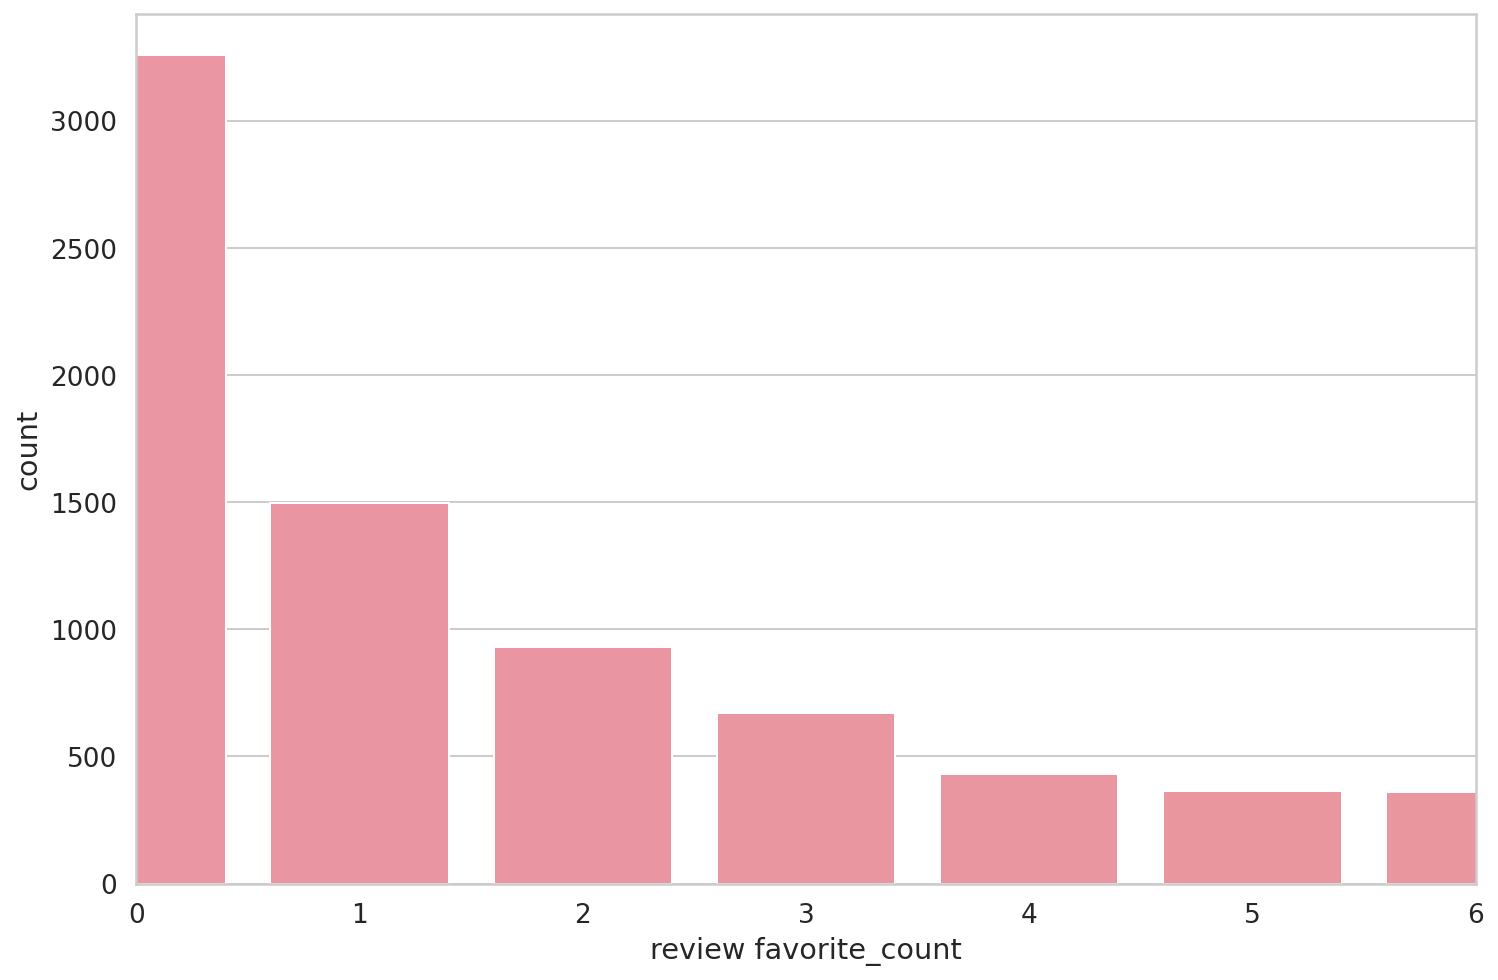

In [ ]:
import seaborn as sns
sns.countplot(df. retweetcount  	)
plt.xlim([0, 6]);
plt.xlabel('review favorite_count');

convertir l'ensemble de données en sentiments négatifs, neutres et positifs

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


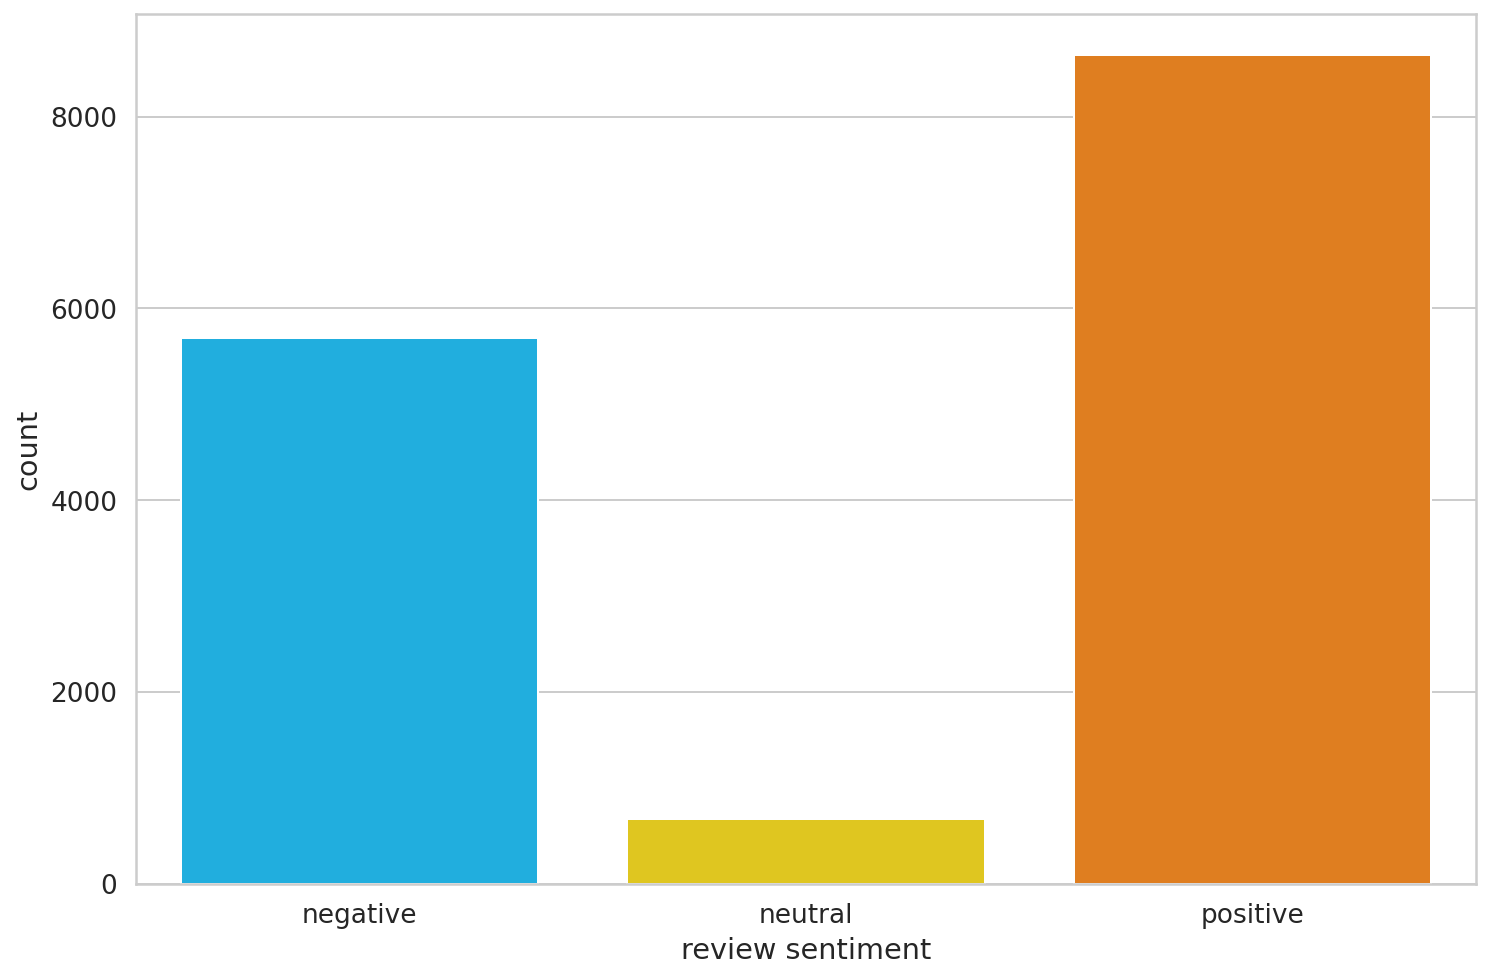

In [ ]:
def to_sentiment(rating):
  rating = float(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.  retweetcount  	.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);


load a pre-trained BertTokenizer:

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

convert the text to tokens and tokens to unique integers (ids)

To understand the tokenization process we’ll use this text :

In [ ]:
sample_txt  = 'If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that	'

In [ ]:
tokens = tokenizer.tokenize(sample_txt )
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt }')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that	
   Tokens: ['If', 'I', 'smelled', 'the', 'scent', 'of', 'hand', 'sa', '##ni', '##ti', '##zers', 'today', 'on', 'someone', 'in', 'the', 'past', ',', 'I', 'would', 'think', 'they', 'were', 'so', 'into', '##xi', '##cated', 'that']
Token IDs: [1409, 146, 9317, 1103, 5974, 1104, 1289, 21718, 2605, 3121, 26542, 2052, 1113, 1800, 1107, 1103, 1763, 117, 146, 1156, 1341, 1152, 1127, 1177, 1154, 8745, 11603, 1115]


 marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

must add [CLS] this token to the start of each sentence, so BERT knows we’re doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

a special token for padding: (remplissage)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

 Everything else can be encoded using the [UNK] (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=30,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
 truncation=True,
  return_attention_mask=True,
  return_tensors="pt",  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 30:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

30


tensor([  101,  1409,   146,  9317,  1103,  5974,  1104,  1289, 21718,  2605,
         3121, 26542,  2052,  1113,  1800,  1107,  1103,  1763,   117,   146,
         1156,  1341,  1152,  1127,  1177,  1154,  8745, 11603,  1115,   102])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

30


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])

inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'If',
 'I',
 'smelled',
 'the',
 'scent',
 'of',
 'hand',
 'sa',
 '##ni',
 '##ti',
 '##zers',
 'today',
 'on',
 'someone',
 'in',
 'the',
 'past',
 ',',
 'I',
 'would',
 'think',
 'they',
 'were',
 'so',
 'into',
 '##xi',
 '##cated',
 'that',
 '[SEP]']

BERT works with fixed-length sequences. We’ll use a simple strategy to 


choose the max length. Let’s store the token length of each review:




In [ ]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(str(txt))
  token_lens.append(len(tokens))

 plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


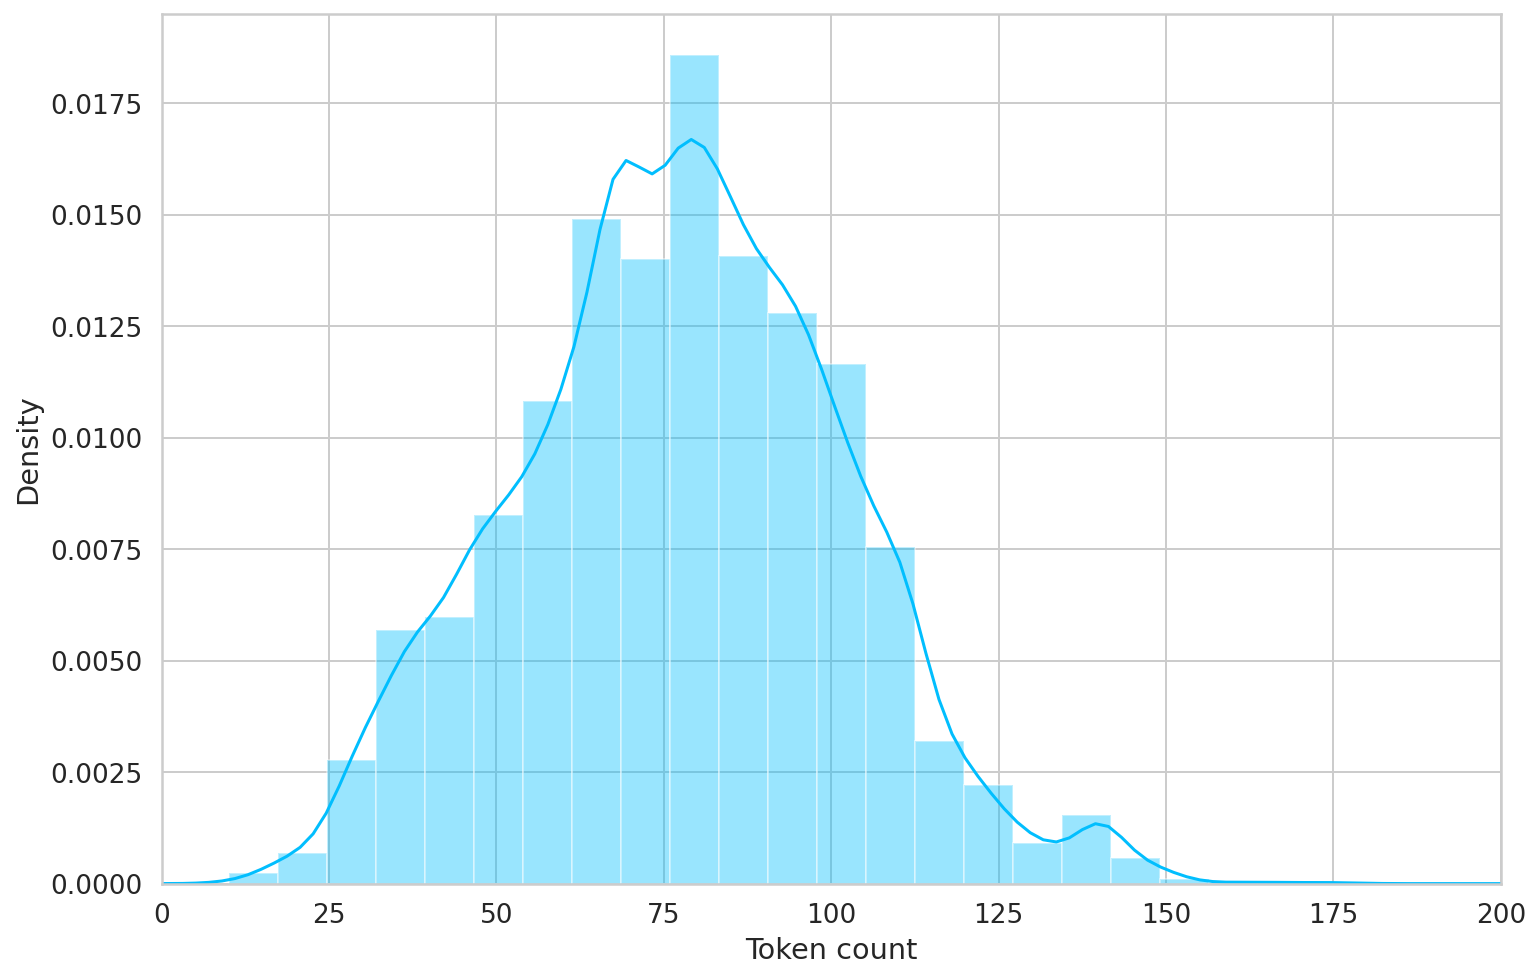

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 512

We have all building blocks required to create a PyTorch dataset. 

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it’ll be easier to evaluate the predictions from our model. Let’s split the data:

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((13500, 12), (750, 12), (750, 12))

We also need to create a couple of data loaders. 

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text .to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len 
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let’s have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([5, 512])
torch.Size([5, 512])
torch.Size([5])


**Sentiment Classification with BERT and Hugging Face**

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False   # this is needed to get a tensor as result
)

The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:

In [ ]:
last_hidden_state.shape

torch.Size([1, 30, 768])

768 is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

pooled_output as a summary of the content

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Let’s create an instance and move it to the GPU

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We’ll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([5, 512])
torch.Size([5, 512])


To get the predicted probabilities from our trained model, we’ll apply the softmax function to the outputs:

In [ ]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2115, 0.4674, 0.3211],
        [0.2230, 0.4014, 0.3756],
        [0.3302, 0.2728, 0.3970],
        [0.1898, 0.4192, 0.3910],
        [0.5437, 0.2126, 0.2437]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

**Training**

To reproduce the training procedure from the BERT paper, we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10
validation_split=0.3
verbose=0
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Let’s continue with writing a helper function for training our model for one epoch:



In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

Let’s write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(attention_mask, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We’ll also store the training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 11)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
       

Epoch 1/10
-----------
Train loss 0.6305815570873933 accuracy 0.7592592592592593
Val   loss 0.5257891223432186 accuracy 0.3893333333333333

Epoch 2/10
-----------
Train loss 0.38051986680030864 accuracy 0.9054814814814814
Val   loss 0.3392776112204107 accuracy 0.3893333333333333

Epoch 3/10
-----------
Train loss 0.2549167342672364 accuracy 0.941037037037037
Val   loss 0.29261582283468063 accuracy 0.3893333333333333

Epoch 4/10
-----------
Train loss 0.19335818108847888 accuracy 0.9538518518518518
Val   loss 0.26889984710350595 accuracy 0.3893333333333333

Epoch 5/10
-----------
Train loss 0.16205604698327888 accuracy 0.9602222222222222
Val   loss 0.2601625481757704 accuracy 0.3893333333333333

Epoch 6/10
-----------
Train loss 0.13365309468378353 accuracy 0.9649629629629629
Val   loss 0.2720321896360717 accuracy 0.3893333333333333

Epoch 7/10
-----------
Train loss 0.10903427790469492 accuracy 0.9693333333333333
Val   loss 0.23348628499397212 accuracy 0.3893333333333333

Epoch 8/10
--

this took some time! We can look at the training vs validation accuracy:

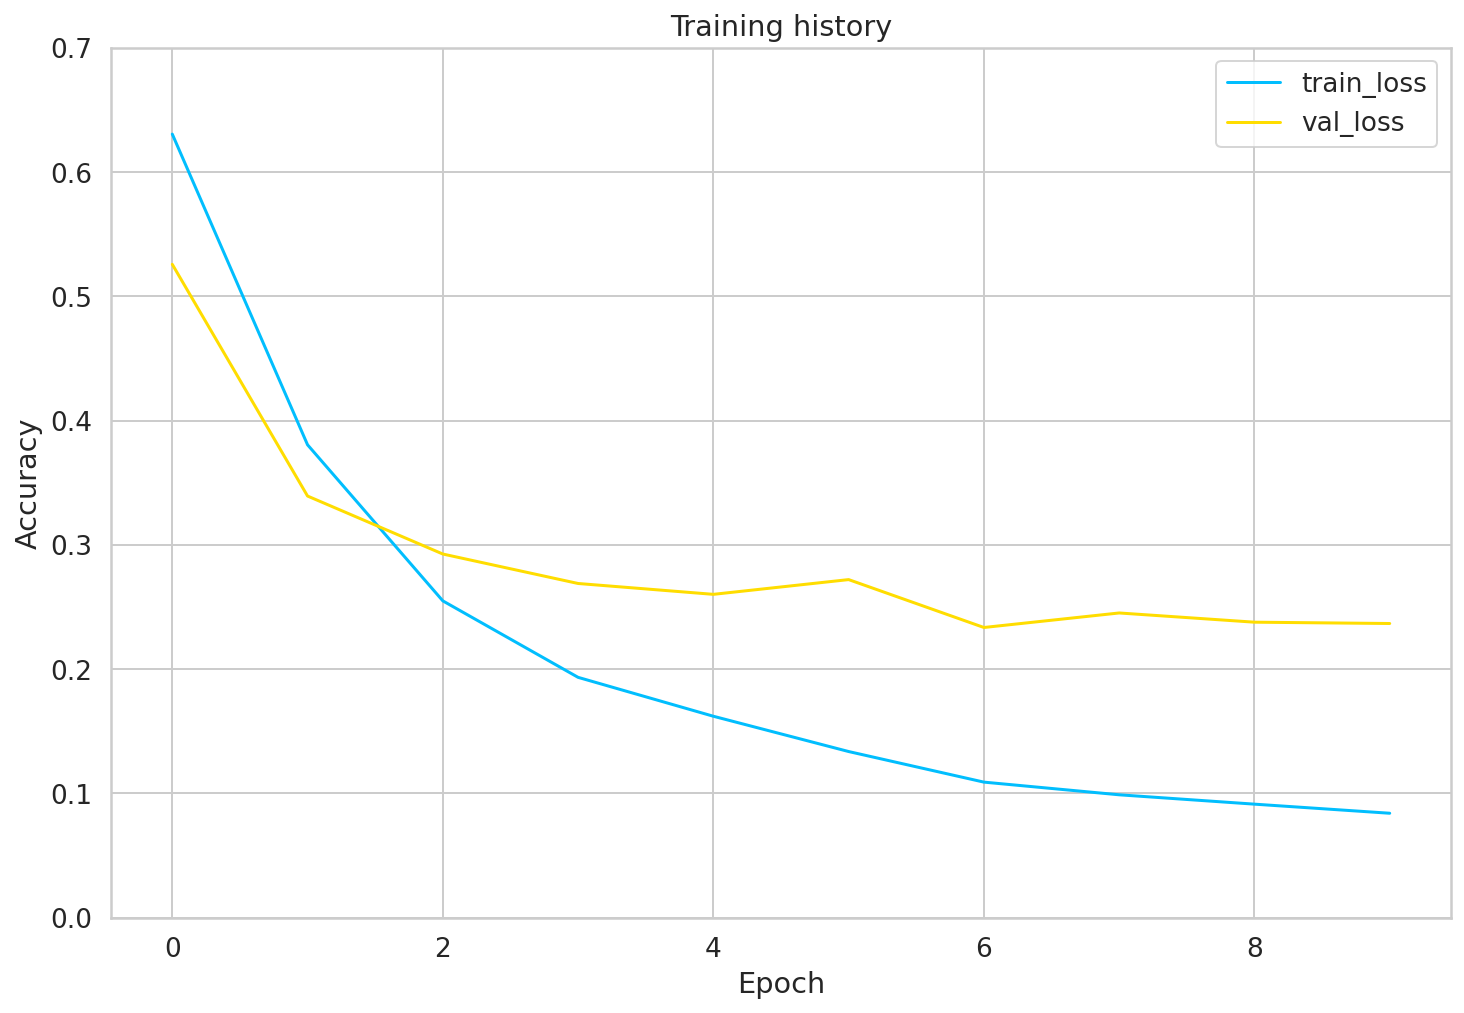

In [ ]:

plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')


plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.7]);



In [ ]:

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.368


We’ll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities:

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader, 
)

Let’s have a look at the classification report





In [ ]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names,zero_division=0))

              precision    recall  f1-score   support

    negative       0.97      0.91      0.94       276
     neutral       0.51      0.66      0.58        32
    positive       0.95      0.97      0.96       442

    accuracy                           0.93       750
   macro avg       0.81      0.84      0.82       750
weighted avg       0.94      0.93      0.94       750



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We’ll continue with the confusion matrix:



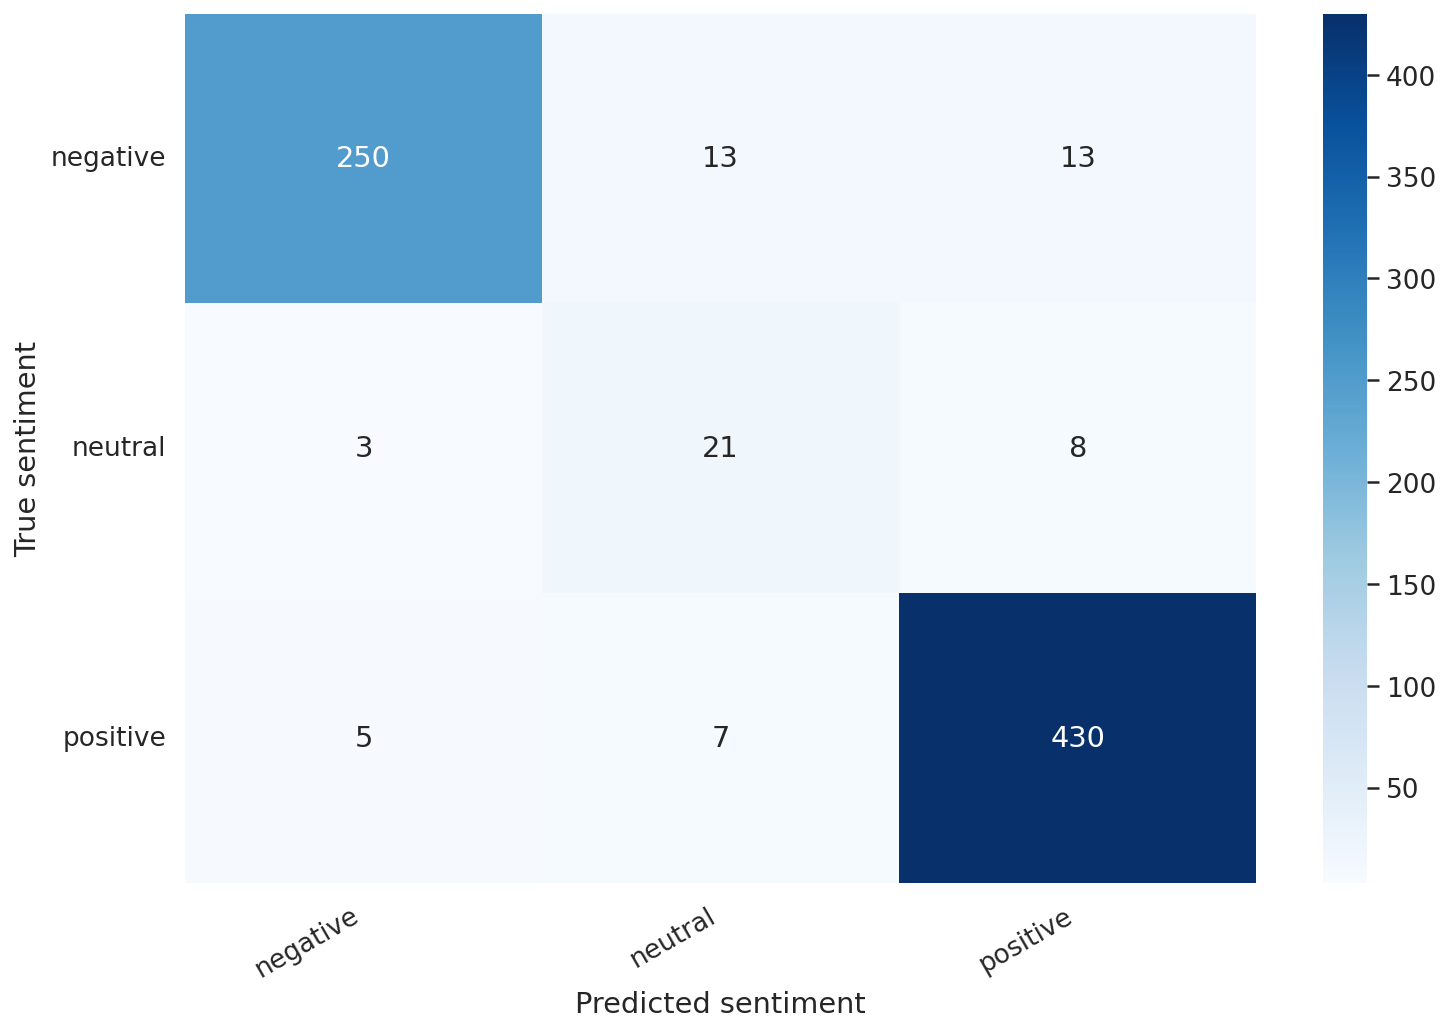

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model. But let’s have a look at an example from our test data:

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values':len( y_pred_probs[idx])
})


In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

How Over 25,000 COVID-19 Patients Got Infected With The Virus While
Being Treated In The Hospital For Something Else. Click on the link to
see very shocking details https://t.co/BilqIYaToE  #COVID19
#coronavirusuk #COVIDSecondWave #COVID19UK https://t.co/T2q0ZzBDw7

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

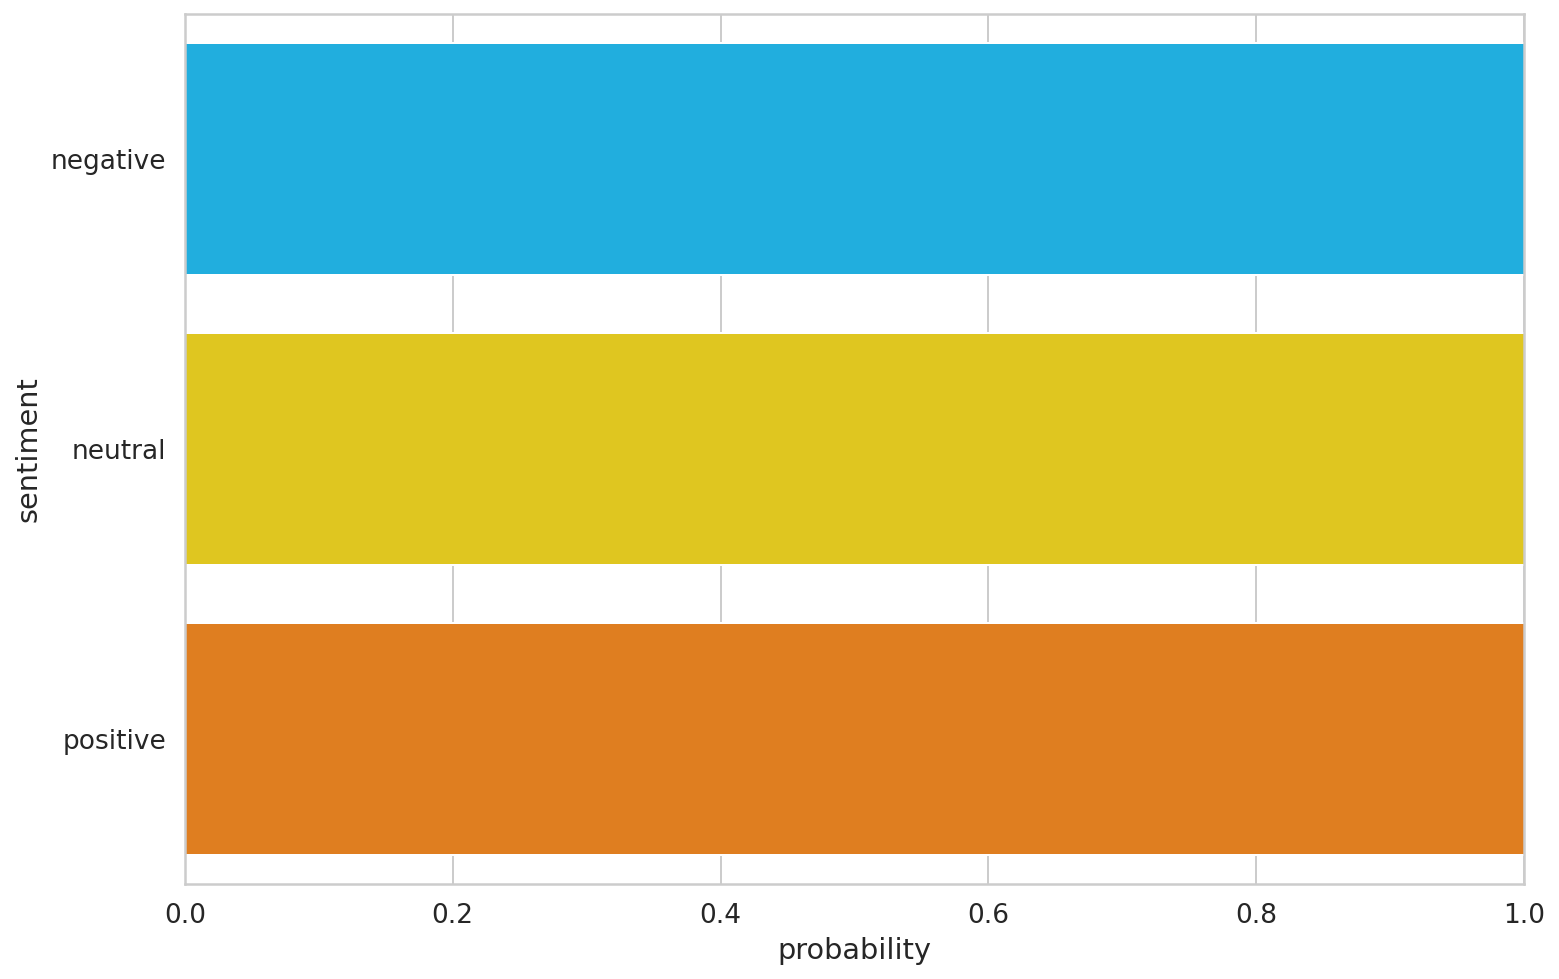

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on Raw Text

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let’s get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: I love completing my todos! Best app ever!!!
Sentiment  : negative
